In [1]:
from openpilot.tools.lib.comma_car_segments import get_comma_car_segments_database
from openpilot.selfdrive.car.ford.values import CAR

database = get_comma_car_segments_database()

platforms = [c.value for c in CAR]

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /mnt/c/Users/camer/AppData/Local/Programs/Microsoft VS Code


In [2]:
import random

from tqdm.contrib.concurrent import thread_map

from openpilot.tools.lib.logreader import LogReader


INSTRUMENT_PANEL = 0x43A


def get_first_can_frame(identifier, address) -> tuple[float, bool] | None:
  t0 = None
  for msg in LogReader(identifier):
    if t0 is None:
      t0 = msg.logMonoTime
    if msg.which() != 'can':
      continue
    for can in msg.can:
      if can.address == address:
        t = (msg.logMonoTime - t0) / 1e9
        is_metric = bool(can.dat[6] & 0x40)
        return t, is_metric
  return None


results = list(thread_map(lambda identifier: get_first_can_frame(identifier, INSTRUMENT_PANEL), [
  segment for platform in platforms
  for segment in random.sample(database[platform], min(len(database[platform]), 100))
]))

  0%|          | 0/467 [00:00<?, ?it/s]

Min time: 0.00s, Max time: 0.99s

is_metric
False    455
True       1
Name: count, dtype: int64


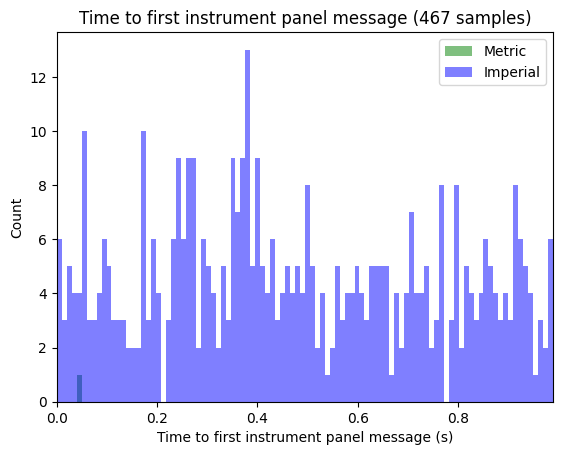

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(results, columns=['time', 'is_metric'])

# plot, color by metric/imperial
x_metric = df.loc[df.is_metric == True, 'time']
x_imperial = df.loc[df.is_metric == False, 'time']

kwargs = dict(alpha=0.5, bins=100)

plt.hist(x_metric, **kwargs, color='g', label='Metric')
plt.hist(x_imperial, **kwargs, color='b', label='Imperial')

plt.xlabel('Time to first instrument panel message (s)')
plt.ylabel('Count')
plt.title(f'Time to first instrument panel message ({len(results)} samples)')
plt.legend()

min_time = df['time'].min()
max_time = df['time'].max()
print(f'Min time: {min_time:.2f}s, Max time: {max_time:.2f}s')
plt.xlim(min_time, max_time)
print()

print(df['is_metric'].value_counts())